## Automated Diabetic Retinopathy Screening Proof-of-Concept (PoC)

### 🎯 **Objective**
The goal of this initial phase is to **scan the raw dataset and create a clean, reliable metadata file**. This file will serve as the single source of truth for our project, mapping every valid image to its correct diagnosis and ensuring the integrity of our dataset by removing duplicates and corrupted files.

This "metadata-first" approach is highly efficient as it avoids loading large images into memory. Instead, we create a lightweight map that will guide all future processing and modeling steps.

---

### 🧾 **Business Rationale (Senior BA Perspective)**
As the lead for this PoC, my primary goal is to de-risk the project early. Before we invest significant computational resources into image processing and model training, we must first **validate and audit our primary asset: the data.**

An unreliable dataset leads to untrustworthy models. By creating a clean metadata file, we establish a foundational layer of data governance. This ensures that our subsequent analyses are reproducible, traceable, and built upon a verified and complete dataset. This step is non-negotiable for building a robust, production-ready AI solution in a regulated medical environment.

---

### 📂 **Dataset**
We are using the raw data from the [Kaggle APTOS 2019 Blindness Detection](https://www.kaggle.com/competitions/aptos2019-blindness-detection/data) competition. The key components are:
- `train_images/`: A folder containing all raw images.
- `train.csv`: A manifest file linking image IDs to their diagnoses.

#### Conclusion & Next Steps
This phase successfully transformed a raw, inconsistent collection of images into a standardized, analysis-ready dataset. By creating this repeatable preprocessing pipeline, we have not only curated the data for this PoC but have also developed a template for ingesting future clinical data. **The successful completion of this phase provides the high-quality foundation necessary to proceed with exploratory analysis**.

In [3]:
# Import necessary libraries

import os
import hashlib
import pandas as pd
from tqdm import tqdm
from PIL import Image  # Pillow is used for its efficient image verification capabilities.
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


### Load and Prepare Initial Metadata

Our first action is to load the `train.csv` manifest provided with the dataset. We will then enrich this data by creating a full, verifiable path to each image file.

In [4]:
BASE_DIR = '.'
TRAIN_IMG_DIR = os.path.join(BASE_DIR, 'Data/aptos2019-blindness-detection/train_images')
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'Data/aptos2019-blindness-detection/train.csv')

# Load the CSV
try:
    df = pd.read_csv(TRAIN_CSV_PATH)
    print(f"Successfully loaded {TRAIN_CSV_PATH}. Found metadata for {len(df)} images.")
except FileNotFoundError:
    print(f"[FATAL] Could not find {TRAIN_CSV_PATH}. Please ensure it is in the correct directory.")
    df = pd.DataFrame() # Create an empty dataframe to avoid downstream errors

# Create the full filepath for each image. This is a crucial step to make our
# metadata self-contained and directly usable.
if not df.empty:
    df['filepath'] = df['id_code'].apply(lambda x: os.path.join(TRAIN_IMG_DIR, f"{x}.png"))
    print("\nSample of the initial DataFrame with filepaths:")
    print(df.head())

Successfully loaded .\Data/aptos2019-blindness-detection/train.csv. Found metadata for 3662 images.

Sample of the initial DataFrame with filepaths:
        id_code  diagnosis                                           filepath
0  000c1434d8d7          2  .\Data/aptos2019-blindness-detection/train_ima...
1  001639a390f0          4  .\Data/aptos2019-blindness-detection/train_ima...
2  0024cdab0c1e          1  .\Data/aptos2019-blindness-detection/train_ima...
3  002c21358ce6          0  .\Data/aptos2019-blindness-detection/train_ima...
4  005b95c28852          0  .\Data/aptos2019-blindness-detection/train_ima...


### Step 3: Analyze Class Distribution

Before cleaning the data, it's essential to understand its composition. A significant class imbalance—where some diagnoses are much more common than others—is a critical finding that will heavily influence our modeling strategy later on.

Class Distribution:
diagnosis_label
Mild                 370
Moderate             999
No DR               1805
Proliferative DR     295
Severe               193
Name: count, dtype: int64


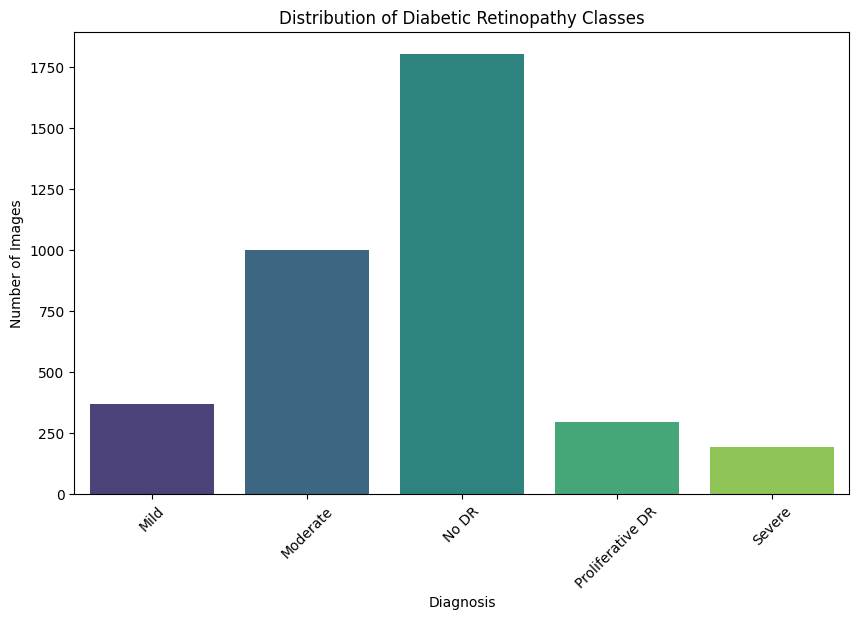

In [5]:
# Rationale: A visual inspection of the class distribution provides an immediate and clear understanding of the dataset's imbalance. This informs stakeholders and the modeling team of the need for mitigation strategies like class weighting or stratified sampling.

if not df.empty:
    # Map numeric diagnosis to human-readable labels for plotting
    diagnosis_map = {
        0: 'No DR',
        1: 'Mild',
        2: 'Moderate',
        3: 'Severe',
        4: 'Proliferative DR'
    }
    df['diagnosis_label'] = df['diagnosis'].map(diagnosis_map)

    # Calculate counts
    class_counts = df['diagnosis_label'].value_counts().sort_index()
    print("Class Distribution:")
    print(class_counts)

    # Visualize
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="viridis", legend=False)
    plt.title('Distribution of Diabetic Retinopathy Classes')
    plt.xlabel('Diagnosis')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

### Verify Data Integrity (Check for Corrupted & Duplicate Images)

This is a critical data governance step. We will iterate through every file path in our DataFrame to ensure it points to a valid, readable, and unique image.
- **Corrupted Files:** We will use Pillow's `Image.verify()` method, which is a fast way to check if a file is a valid image without loading all pixel data.
- **Duplicate Files:** We will compute an MD5 hash (a unique digital fingerprint) for each file. By tracking these hashes, we can identify and discard any exact duplicates.

In [6]:
if not df.empty:
    def get_file_hash(filepath):
        """Calculates the MD5 hash of a file for duplicate detection."""
        with open(filepath, "rb") as f:
            return hashlib.md5(f.read()).hexdigest()

    valid_images = []
    hashes = set()

    # Using tqdm for a progress bar
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Verifying Images"):
        filepath = row['filepath']
        try:
            # 1. Check if the file exists
            if not os.path.exists(filepath):
                print(f"File not found, skipping: {filepath}")
                continue

            # 2. Check if it's a valid image that can be opened and verified
            img = Image.open(filepath)
            img.verify()

            # 3. Check for duplicates using hashing
            file_hash = get_file_hash(filepath)
            if file_hash in hashes:
                continue  # Skip if it's a duplicate

            hashes.add(file_hash)
            valid_images.append(row)

        except Exception as e:
            print(f"Skipping corrupted or problematic file: {filepath} due to {e}")

    # Create a new, clean DataFrame
    clean_df = pd.DataFrame(valid_images)

    print(f"\nOriginal image count: {len(df)}")
    print(f"Clean image count: {len(clean_df)}")
    print(f"Removed {len(df) - len(clean_df)} missing, corrupted, or duplicate images.")

Verifying Images: 100%|██████████| 3662/3662 [01:13<00:00, 49.55it/s]


Original image count: 3662
Clean image count: 3534
Removed 128 missing, corrupted, or duplicate images.


### Save Clean Metadata

This is the **final and most important step** of this notebook. We will now serialize our `clean_df` DataFrame to a CSV file. This single, clean file will serve as the starting point for all future notebooks (EDA, processing, and modeling), ensuring a consistent and reproducible workflow.

In [7]:
if 'clean_df' in locals() and not clean_df.empty:
    output_path = os.path.join(BASE_DIR, "Data/aptos2019-blindness-detection/clean_metadata.csv")
    clean_df.to_csv(output_path, index=False)
    print(f"\n✅ Clean metadata successfully saved to: {output_path}")
    print("Sample of the final, clean DataFrame:")
    print(clean_df.head())
else:
    print("\n⚠️ Clean DataFrame not created or is empty. Skipping save.")


✅ Clean metadata successfully saved to: .\Data/aptos2019-blindness-detection/clean_metadata.csv
Sample of the final, clean DataFrame:
        id_code  diagnosis                                           filepath  \
0  000c1434d8d7          2  .\Data/aptos2019-blindness-detection/train_ima...   
1  001639a390f0          4  .\Data/aptos2019-blindness-detection/train_ima...   
2  0024cdab0c1e          1  .\Data/aptos2019-blindness-detection/train_ima...   
3  002c21358ce6          0  .\Data/aptos2019-blindness-detection/train_ima...   
4  005b95c28852          0  .\Data/aptos2019-blindness-detection/train_ima...   

    diagnosis_label  
0          Moderate  
1  Proliferative DR  
2              Mild  
3             No DR  
4             No DR  
